# Swin Transformer

- paper : https://arxiv.org/pdf/2103.14030
- official code : https://github.com/microsoft/Swin-Transformer






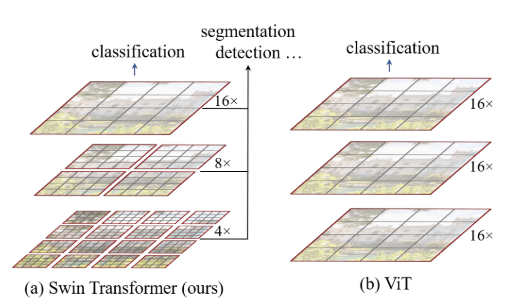

- Vision Transformer tutorial :https://github.com/seonm9119/tutorials/blob/main/Vision%20Transformer.ipynb


논문에서 저자는 Transformer 모델이 자연어 처리(NLP) 분야에서는 우수한 성능을 보이지만, 컴퓨터 비전 분야에 적용할 때 두 가지 주요 어려움이 있다고 지적한다.

- Scale: NLP에서는 단어의 크기(scale)는 고정적이지만, 이미지에는 다양한 스케일이 존재한다. Transformer 기반 모델들은 이미지의 스케일이 고정되어 있다고 가정하기 때문에, 다양한 스케일을 적절히 처리하는 데 어려움이 있다.

- High Resolution: 이미지의 해상도가 커질수록 처리해야 할 연산량이 기하급수적으로 증가한다. 높은 해상도의 이미지는 입력 데이터의 크기가 매우 크기 때문에, Transformer 기반 모델은 시간 복잡도가 제곱적으로 증가한다.



이미지에서 스케일(Scale)은 이미지 내의 객체들을 의미한다. NLP에서 각 단어 토큰은 독립적으로 의미를 가지지만, 이미지를 고정된 크기로 분할하여 토큰화하면 하나의 토큰이 다양한 크기의 객체를 항상 포착할 수는 없다. 이러한 차이점 때문에 Transformer를 이미지 처리에 단순히 적용하는 데 어려움이 있다. 따라서 저자는 계층적 구조를 통해 이 문제를 해결한다고 한다. 왼쪽 그림과 같이 윈도우의 크기를 계층적으로 달리하여 이미지의 다양한 스케일을 더 잘 포착하도록 하는 거다. 또한 윈도우 단위의 어텐션 메커니즘을 통해 고해상도 이미지에서 연산량을 줄이는 방법을 제안한다.

요약하면, 저자의 주요 아이디어는 Transformer에 윈도우를 도입하는 것이다. 윈도우를 통해 모델을 계층적으로 설계하고, window attention을 사용하여 연산량을 줄이는 것이다. 그럼 어떻게 Transformer에 윈도우를 도입하는지에 대해 자세히 알아보자!

# Let's GO!

### Setup Codes

In [1]:
%load_ext autoreload
%autoreload 2

#### Google Colab Setup
we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

#### Import packages

In [ ]:
!pip install einops
!pip install timm

In [4]:
import torch
import torch.nn as nn

### Load Datasets

we will be working on the CIFAR-100, CIFAR-10 dataset, which has 60,000 training and 10,000 test images. we will use the PyTorch CIFAR-100, CIFAR-10 wrapper. See the [documentation](https://github.com/pytorch/vision/blob/main/torchvision/datasets/cifar.py) for more information about the interface.

In [5]:
from torch.utils.data import DataLoader

# custom packages
from data.cifar import CIFAR100, CIFAR10

In [6]:
# for pre-train
train_dataset = CIFAR100(root='.', train=True, image_size=32)
test_dataset = CIFAR100(root='.', train=False, image_size=32)

pre_train = {}
pre_train['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True)
pre_train['test'] = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 169001437/169001437 [00:03<00:00, 48993856.04it/s]


Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


In [7]:
# for fine-tune
train_dataset = CIFAR10(root='.', train=True, image_size=32)
test_dataset = CIFAR10(root='.', train=False, image_size=32)

fine_tune = {}
fine_tune['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True)
fine_tune['test'] = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 45475282.80it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


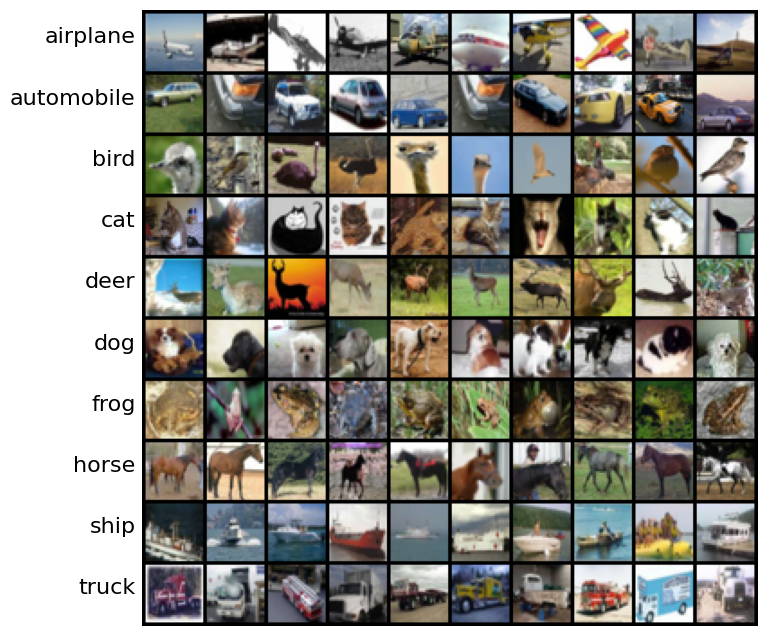

In [8]:
train_dataset.visualize_dataset(samples_per_class=10)

## Build a Swin Transformer

In [ ]:
from models.vit.sublayers import PatchEmbed, Mlp
from models.vit.attention import Attention

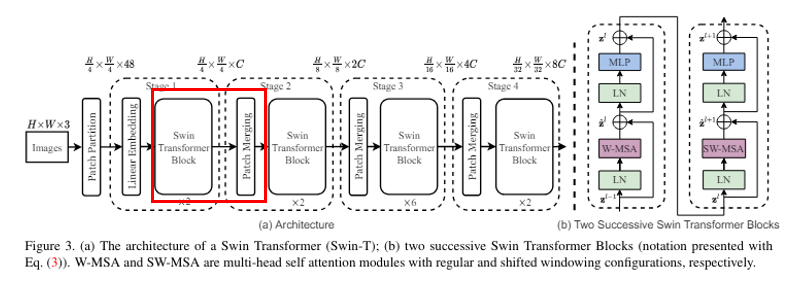

전체 모델구조는 총 4개의 스테이지(stage)로 구성된다. 논문의 모델 구조를 약간 변형하여 빨간 박스 하나가 하나의 스테이지가 되도록 구현했다. 공식 코드에서도 빨간 박스가 하나의 스테이지로 간주된다.

In [ ]:
class SwinTransformer(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=4,
                 in_chans=3,
                 embed_dim=96,
                 num_classes=1000,
                 depths=[2, 2, 6, 2],
                 num_heads=[3, 6, 12, 24],
                 window_size=7,
                 mlp_ratio=4.,
                 dropout=0.1):
        super().__init__()

        num_layers = len(depths)
        resolution = img_size // patch_size
        num_features = int(embed_dim * 2 ** (num_layers - 1))
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.patch_embed = PatchEmbed(img_size=img_size,
                                      patch_size=patch_size,
                                      in_chans=in_chans,
                                      embed_dim=embed_dim)

        self.stages = nn.Sequential(*[
            SwinLayer(dim=int(embed_dim * (2 ** _idx)),
                      depth=depths[_idx],
                      num_heads=num_heads[_idx],
                      resolution= int(resolution // (2 ** _idx)),
                      window_size=window_size,
                      mlp_ratio=mlp_ratio,
                      dropout=dropout,
                      downsampling=True if _idx < (num_layers - 1) else False)
            for _idx in range(num_layers)])

        self.head = nn.Linear(num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x):

      x = self.patch_embed(x)
      x = self.stages(x)


      x = self.avgpool(x.transpose(1, 2))
      x = torch.flatten(x, 1)
      x = self.head(x)
      return x

In [ ]:
class SwinLayer(nn.Module):
    def __init__(self, dim,
                 depth,
                 num_heads,
                 resolution,
                 window_size=7,
                 mlp_ratio=4.,
                 dropout=0.1,
                 downsampling=True):
        super().__init__()

        self.blocks = nn.Sequential(*[
            SwinTransformerBlock(dim=dim,
                                 num_heads=num_heads,
                                 resolution=resolution,
                                 window_size=window_size,
                                 shift_size=0 if (_idx % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 dropout=dropout) for _idx in range(depth)])


        self.downsampling = PatchMerging(dim, resolution) if downsampling else nn.Identity()

    def forward(self, x):
        x = self.blocks(x)
        x = self.downsampling(x)
        return x

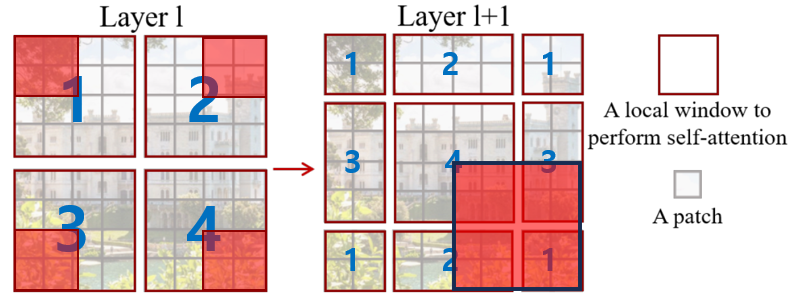

저자의 핵심 아이디어는 Transformer에 윈도우(window)를 도입하는 것이다. 각 윈도우는 주변 패치를 포함하고 있는데, 위의 오른쪽 그림을 보면 이해하기 쉽다. 각 번호는 윈도우를 나타내고, 윈도우 안의 사각형은 패치를 나타낸다. 이후 각 윈도우 단위로 어텐션을 진행하게 되는데, 이를 윈도우 어텐션이라고 하며, 논문에서는 W-MSA(Window Multi-Head Self-Attention)라고 표현한다.

하지만 여기서 문제가 발생합니다. 윈도우 단위로 어텐션을 진행하면, 다른 윈도우 간의 어텐션을 계산할 수 없게 된다. 즉, 1번 윈도우 내부에서만 어텐션을 진행하면, 1번과 2번 윈도우 내부가의 패치간의 연관이 있더라도 윈도우 단위로 연산이 이루어지기 때문에 2번 윈도우와의 관계를 포착할 수 없게 되는 것이다. 이러한 문제를 해결하기 위해 저자는 시프트 윈도우(shift window)를 도입한다. 이는 논문에서 SW-MSA(Shifted Window Multi-Head Self-Attention)로 언급된다.

오른쪽 그림은 왼쪽 그림을 시프트한 윈도우를 나타낸다. 시프트를 통해 각 윈도우는 이전 레이어에 없던 다른 영역의 패치를 포함하게 되어, 윈도우 간의 관계를 포착할 수 있게 된다. 그러나 이 과정에서 또 다른 문제가 발생한다. 이미지를 시프트하면 서로 연관이 없는 영역들이 윈도우에 포함될 수 있다. 오른쪽 빨간 박스를 자세히 보면, 1번, 2번, 3번 윈도우의 패치들이 포함되어 있다. 즉, 서로 연관이 전혀 없는 패치들이 한 윈도우에 포함될 수 있다. 이를 해결하기 위해 저자는 윈도우 내부의 연관이 없는 부분을 마스킹하여, 연관 있는 패치들만 어텐션을 수행할 수 있게 한다.

In [9]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size * window_size, C)
    return windows

In [10]:
def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    return x

In [11]:
def generate_mask(resolution, window_size, shift_size):

  H = W = resolution
  img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
  h_slices = (slice(0, -window_size),
              slice(-window_size, -shift_size),
              slice(-shift_size, None))
  w_slices = (slice(0, -window_size),
              slice(-window_size, -shift_size),
              slice(-shift_size, None))

  cnt = 0
  for h in h_slices:
    for w in w_slices:
      img_mask[:, h, w, :] = cnt
      cnt += 1

  mask_windows = window_partition(img_mask, window_size)
  mask_windows = mask_windows.view(-1, window_size * window_size)
  attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)

  attn_mask = attn_mask.masked_fill(attn_mask != 0, -float('inf'))
  return attn_mask == 0

아래의 코드를 통해 어떠한 방식으로 연산이 되는지 확인해 보길 바란다.

In [12]:
H = W = 4
window_size = 2
shift_size = window_size // 2

x = torch.arange(1, 17).reshape(4, 4)
print(f"patched image\n{x}\n")
img = x.unsqueeze(0).unsqueeze(-1)

# shift image
shifted_img = torch.roll(img, shifts=(-shift_size, -shift_size), dims=(1, 2))
print(f"shifted image\n{shifted_img.squeeze(0).squeeze(-1)}")

patched image
tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])

shifted image
tensor([[ 6,  7,  8,  5],
        [10, 11, 12,  9],
        [14, 15, 16, 13],
        [ 2,  3,  4,  1]])


In [13]:
window = window_partition(img, window_size)

for i, _window in enumerate(window.squeeze(-1)):
  print(f"window_{i+1} : {_window}")

window_1 : tensor([1, 2, 5, 6])
window_2 : tensor([3, 4, 7, 8])
window_3 : tensor([ 9, 10, 13, 14])
window_4 : tensor([11, 12, 15, 16])


In [14]:
attn_mask = generate_mask(H, window_size, shift_size)

for i, _attn_mask in enumerate(attn_mask):
  print(f"window {i+1} attn mask\n{_attn_mask}\n")

window 1 attn mask
tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

window 2 attn mask
tensor([[ True, False,  True, False],
        [False,  True, False,  True],
        [ True, False,  True, False],
        [False,  True, False,  True]])

window 3 attn mask
tensor([[ True,  True, False, False],
        [ True,  True, False, False],
        [False, False,  True,  True],
        [False, False,  True,  True]])

window 4 attn mask
tensor([[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False,  True]])



In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(self,dim,
                 num_heads,
                 resolution,
                 window_size=7,
                 shift_size=2,
                 mlp_ratio=4.,
                 dropout=0.1,):
        super().__init__()

        self.window_size = window_size
        self.resolution = resolution
        self.shift_size = shift_size

        self.num_heads = num_heads

        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

        self.attn = Attention(dim,
                              num_heads=num_heads,
                              attn_drop=dropout,
                              proj_drop=dropout)


        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim,
                       hidden_features=mlp_hidden_dim,
                       drop=dropout)


        attn_mask = generate_mask(self.resolution, self.window_size, self.shift_size) if self.shift_size > 0 else None
        self.register_buffer("attn_mask", attn_mask)


    def forward(self, x):

        H = W = self.resolution
        B, L, C = x.shape
        shortcut = x

        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # shift patches
        if self.shift_size > 0:
          x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

        # window attention
        mask = self.attn_mask.repeat(B, 1, 1).unsqueeze(1) if self.attn_mask is not None else None
        windows = window_partition(x, self.window_size)
        window_attn, _ = self.attn(windows, mask)
        x = window_reverse(window_attn, self.window_size, H, W)

        # reverse patches
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))


        x = x.view(B, H * W, C)
        # same as transformer blocks
        attn_output = shortcut + self.dropout(x)
        ffn_output = self.mlp(self.norm2(attn_output))
        return attn_output + self.dropout(ffn_output)

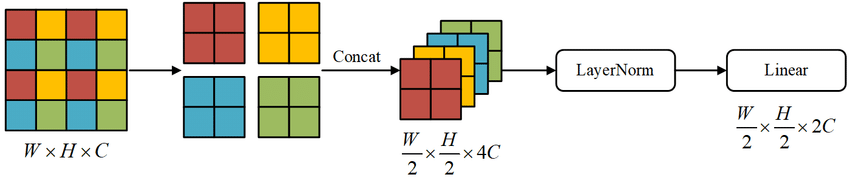

저자는 패치를 결합하여 계층적으로 다양한 스케일을 포착할 수 있게 한다. 패치를 결합하는 방식은 위 이미지를 통해 직관적으로 쉽게 이해할 수 있다.

In [ ]:
class PatchMerging(nn.Module):
    def __init__(self, dim,
                 resolution):
        super().__init__()

        self.resolution = resolution
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(4 * dim)

    def forward(self, x):

        H = W = self.resolution
        B, L, C = x.shape

        x = x.view(B, H, W, C)

        # per 2
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]

        x = torch.cat([x0, x1, x2, x3], -1)
        x = x.view(B, -1, 4 * C)

        x = self.norm(x)
        x = self.reduction(x)
        return x

## Train a Net

위에서 구현한 모델은 논문의 핵심 개념을 이해하기 쉽도록 간단히 구현한 것이다. 스케줄러, 초기 가중치 설정 등의 세부 사항은 논문과 공식 코드를 참고하여 모델을 더 구체화하길 권장한다. 그럼 구현한 모델을 학습시켜 보자!

In [ ]:
# custom packages
from colab_utils.vit import runner

일반적으로 사전 학습 단계에서는 대규모 데이터셋인 ImageNet을 사용한다. 하지만 우리는 간단한 테스트를 해보기위해 CIFAR-100을 사용하여 모델을 사전 학습시킨다.

In [ ]:
pre_model = SwinTransformer(img_size=32,
                 patch_size=2,
                 in_chans=3,
                 embed_dim=96,
                 num_classes=100,
                 depths=[2, 2, 6, 2],
                 num_heads=[3, 6, 12, 24],
                 window_size=2,
                 mlp_ratio=4.,
                 dropout=0.1)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pre_model.parameters(), lr=2e-4)

In [ ]:
history = runner(pre_model, criterion, optimizer, pre_train, num_epochs=10, msg=2)
torch.save(pre_model.state_dict(), 'pre_train.pth')

Train using cuda
Epoch [2/10]          time: 0:02:43          train Loss: 3.0918          train ACC: 24.01%          val Loss: 2.9515          val ACC: 26.87%
Epoch [4/10]          time: 0:02:43          train Loss: 2.3891          train ACC: 37.66%          val Loss: 2.5285          val ACC: 35.79%
Epoch [6/10]          time: 0:02:47          train Loss: 1.8765          train ACC: 48.84%          val Loss: 2.3751          val ACC: 39.57%
Epoch [8/10]          time: 0:02:49          train Loss: 1.3995          train ACC: 60.25%          val Loss: 2.4089          val ACC: 40.79%
Epoch [10/10]          time: 0:02:47          train Loss: 0.9302          train ACC: 72.25%          val Loss: 2.5830          val ACC: 41.25%

Finished Training
Toral Training Time: 0:13:52
Accuracy of the test images: 40.87%


학습된 모델을 활용하여 다운스트림 태스크로 CIFAR-10의 Classification을 수행해보자!

In [ ]:
fine_model = SwinTransformer(img_size=32,
                 patch_size=2,
                 in_chans=3,
                 embed_dim=96,
                 num_classes=10,
                 depths=[2, 2, 6, 2],
                 num_heads=[3, 6, 12, 24],
                 window_size=2,
                 mlp_ratio=4.,
                 dropout=0.1)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_model.parameters(), lr=2e-4)

In [ ]:
checkpoint = torch.load("pre_train.pth")
checkpoint = {key: val for key, val in checkpoint.items() if 'head' not in key}
fine_model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])

In [ ]:
history = runner(fine_model, criterion, optimizer, fine_tune, num_epochs=5, msg=1)
torch.save(fine_model.state_dict(), 'fine_tune.pth')

Train using cuda
Epoch [1/5]          time: 0:01:22          train Loss: 1.0428          train ACC: 63.02%          val Loss: 0.9300          val ACC: 66.73%
Epoch [2/5]          time: 0:01:21          train Loss: 0.7427          train ACC: 73.87%          val Loss: 0.8334          val ACC: 70.64%
Epoch [3/5]          time: 0:01:21          train Loss: 0.5723          train ACC: 79.60%          val Loss: 0.8247          val ACC: 71.74%
Epoch [4/5]          time: 0:01:21          train Loss: 0.4442          train ACC: 84.26%          val Loss: 0.8786          val ACC: 71.42%
Epoch [5/5]          time: 0:01:22          train Loss: 0.3325          train ACC: 88.27%          val Loss: 0.8906          val ACC: 72.30%

Finished Training
Toral Training Time: 0:06:49
Accuracy of the test images: 72.22%
